# Paper Experiments
In this notebook, we plot paper experiments.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys
sys.path.append("../")

from tqdm import tqdm

Let's plot the experiments.

In [3]:
from src.utils import load_dataset

In [4]:
dataset = "PAMAP"
df_data = load_dataset(dataset)

selection = 63
converters = dict([(column, eval) for column in ["profile", "true_cps", "found_cps"]])
algorithms = ["ClaSS", "FLOSS", "Window"]

records = []

for algorithm in tqdm(algorithms):
    df_profiles = pd.read_csv(f"../experiments/competitor_{dataset}/{algorithm}.csv.gz", converters=converters, compression="gzip")
    row = df_profiles.iloc[selection,:]
    records.append((algorithm, np.array(row.profile), np.array(row.found_cps)))
    
ts_name = df_data["name"].iloc[selection]
ts = df_data.time_series.iloc[selection]
true_cps = df_data.change_points.iloc[selection]

100%|█████████████████████████████████████████████| 3/3 [02:14<00:00, 44.77s/it]


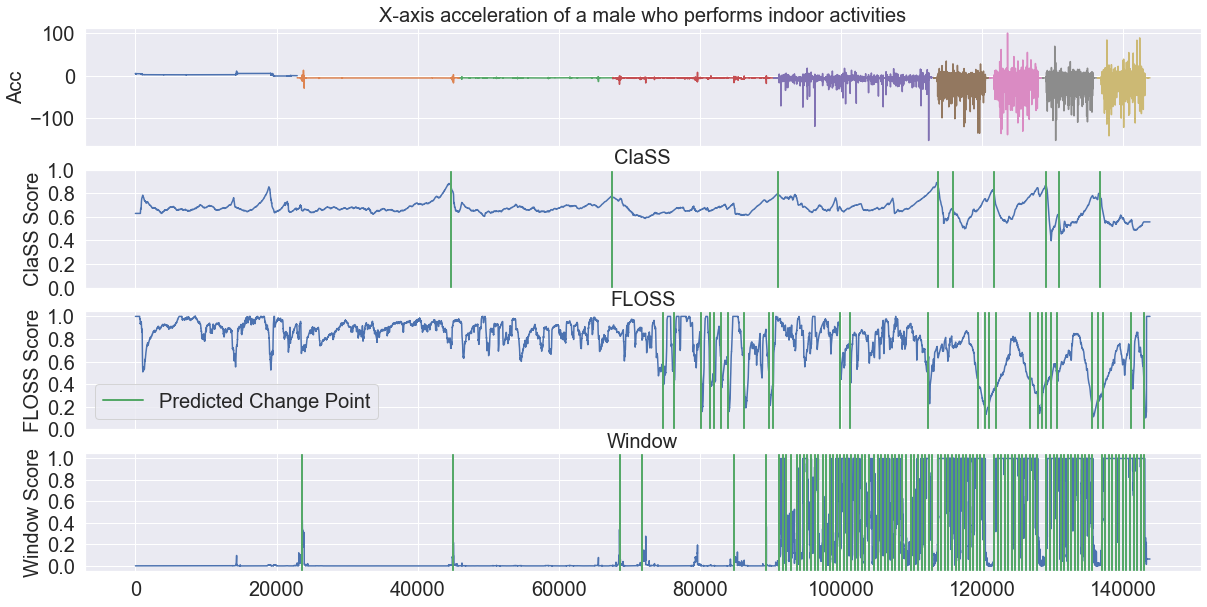

In [5]:
fontsize = 20

fig, axes = plt.subplots(
    4,  
    sharex=True, 
    gridspec_kw={'hspace': .2}, 
    figsize=(20,5 * 2)
)

axes[0].set_title("X-axis acceleration of a male who performs indoor activities", fontsize=fontsize)
axes[0].set_ylabel(f"Acc", fontsize=fontsize)

segments = [0] + true_cps.tolist() + [len(ts)]

for idx in np.arange(0, len(segments)-1):
    axes[0].plot(np.arange(segments[idx], segments[idx+1]), ts[segments[idx]:segments[idx+1]])

for ax, (algorithm, profile, found_cps) in zip(axes[1:], records):
    ax.set_title(algorithm, fontsize=fontsize)
    ax.plot(np.arange(profile.shape[0]), np.clip(profile, 0, 1), color='b')

    for idx, found_cp in enumerate(found_cps):
        ax.axvline(x=found_cp, linewidth=2, color='g', label='Predicted Change Point' if idx == 0 else None)
        
    ax.set_ylabel(f"{algorithm} Score", fontsize=fontsize)
    
    ax.set_yticks(np.arange(0,1+.2,.2))
    
axes[2].legend(prop={'size': fontsize})

for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/comparative_detection_usecase.pdf", bbox_inches="tight")   

In [6]:
dataset = "MIT-BIH-Arr"
df_data = load_dataset(dataset)

selection = 50
converters = dict([(column, eval) for column in ["profile", "true_cps", "found_cps", "found_cps_dx"]])
algorithms = ["ClaSS", "FLOSS", "Window"]

records = []

for algorithm in tqdm(algorithms):
    df_profiles = pd.read_csv(f"../experiments/competitor_{dataset}/{algorithm}.csv.gz", converters=converters, compression="gzip")
    row = df_profiles.iloc[selection,:]
    records.append((algorithm, np.array(row.profile), np.array(row.found_cps), np.array(row.found_cps_dx)))
    
ts_name = df_data["name"].iloc[selection]
ts = df_data.time_series.iloc[selection]
true_cps = df_data.change_points.iloc[selection]

100%|████████████████████████████████████████████| 3/3 [08:39<00:00, 173.29s/it]


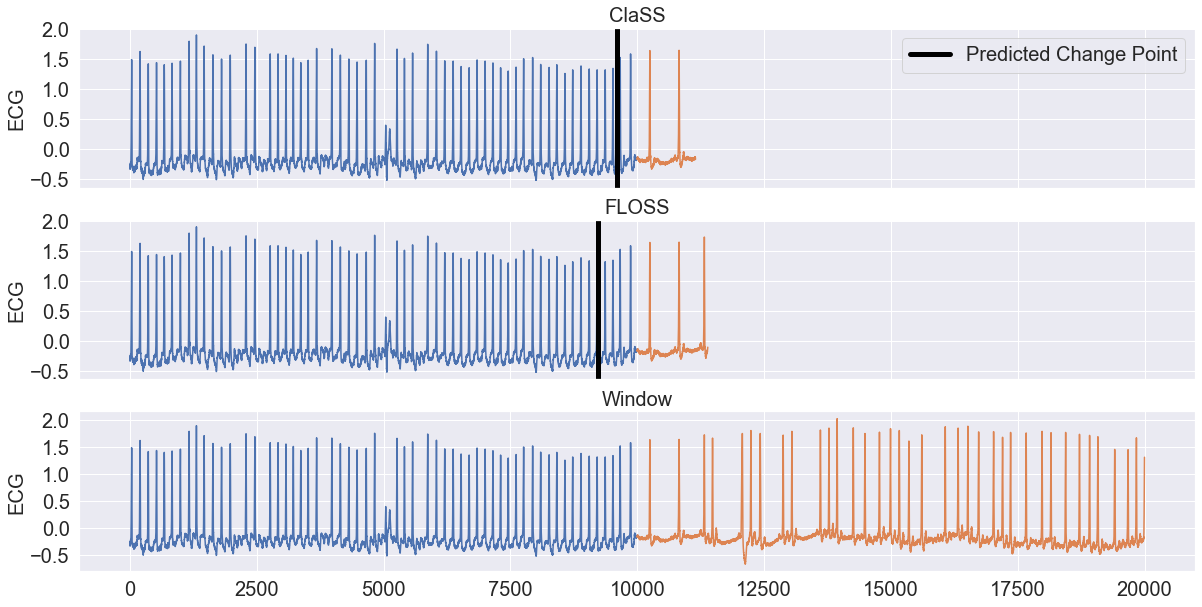

In [7]:
fontsize = 20

fig, axes = plt.subplots(
    len(records),  
    sharex=True, 
    gridspec_kw={'hspace': .2}, 
    figsize=(20,5 * 2)
)

offset, cp = 10_000, 3
ts_cut = ts[true_cps[cp]-offset:true_cps[cp]+offset]
true_cps_cut = [10_000]

for idx, (ax, (algorithm, profile, found_cps, found_cps_dx)) in enumerate(zip(axes, records)):
    cut_cond = np.logical_and(found_cps > true_cps[cp]-offset, found_cps < true_cps[cp]+offset)
    found_dx_cut = found_cps_dx[cut_cond] - (true_cps[cp]-offset)
    
    if len(found_dx_cut) == 0:
        found_dx_cut = np.array([len(ts_cut)])
    
    segments = [0] + true_cps_cut + [len(ts_cut[:np.max(found_dx_cut)])] # 

    for kdx in np.arange(0, len(segments)-1): 
        ax.plot(np.arange(segments[kdx], segments[kdx+1]), ts_cut[segments[kdx]:segments[kdx+1]])
        
    for jdx, true_cp in enumerate(found_cps[cut_cond][-1:] - (true_cps[cp]-offset)):
        ax.axvline(x=true_cp, linewidth=5, color='black', label=f'Predicted Change Point' if idx == 0 and jdx == 0 else None)
    
    ax.set_title(algorithm, fontsize=fontsize)
    ax.set_ylabel(f"ECG", fontsize=fontsize)
    
    if idx == 0:
        ax.legend(prop={'size': fontsize})
        
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
        
plt.savefig(f"../figures/early_detection_usecase.pdf", bbox_inches="tight") 